<a href="https://colab.research.google.com/github/LewisBoulogne/Analysis-of-Big-Data-in-Physics-PRA3024/blob/main/GWDA_1_2_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lewis Boulogne

# **Analysis of Big Data in Physics, PRA3024: GRAVITATIONAL WAVES**
Note: The code below has been extracted from the following sources and repurposed to answer to the questions of the assignment. It was, therefore, not written by myself:
- https://github.com/gwastro/PyCBC-Tutorials/blob/master/tutorial/2_VisualizationSignalProcessing.ipynb
- https://github.com/gwastro/PyCBC-Tutorials/blob/master/tutorial/3_WaveformMatchedFilter.ipynb
- https://canvas.maastrichtuniversity.nl/courses/12320/files/2385104/download?download_frd=1
- https://canvas.maastrichtuniversity.nl/courses/12320/files/2380909/download?download_frd=1
- https://canvas.maastrichtuniversity.nl/courses/12320/files/2379731/download?download_frd=1
- https://canvas.maastrichtuniversity.nl/courses/12320/files/2379738/download?download_frd=1


In [ ]:
import sys
!{sys.executable} -m pip install pycbc ligo-common --no-cache-dir 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 299.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 136.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 MB 110.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 KB 100.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 KB 154.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.2/201.2 KB 223.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 282.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done

In [ ]:
%matplotlib inline
from pycbc.frame import read_frame
from pycbc.filter import highpass_fir, lowpass_fir
from pycbc.waveform import get_fd_waveform
from pycbc.waveform import get_td_waveform
from pycbc.psd import welch, interpolate
from pycbc.catalog import Merger
import pylab
from pycbc.types import  FrequencySeries, TimeSeries
from pycbc.conversions import mass1_from_mchirp_q
import lal

from scipy import interpolate

import numpy as np
from pycbc import frame
import pycbc.psd
import pycbc
from pycbc.filter import resample_to_delta_t, highpass
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.stats import norm 
from pycbc.detector import Detector
from scipy.interpolate import interp1d
from pycbc.filter import sigma

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


PROBLEM 1 

a)
Download the data set from 1. This data set contains a noise time series and an addi-
tional gravitational wave signal, where the sampling rate of the time series is 16384Hz.
The first column of the data set refers to the time. The second and third columns
are the data recorded by LIGO Hanford and Livingston, respectively. For the sake of
convenience in data analysis, we downsample the data at a sampling rate of 2048Hz.

In [ ]:
d = np.load('/content/drive/MyDrive/Ford transit /GW_noisedata-2.npy') #name of the data file noise_ts_4096Hz.npy
dt = d[:, 0]
data_H1 = pycbc.types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0]) #this is to comvert data into GW timeSeries
data_L1 = pycbc.types.TimeSeries(d[:, 2], delta_t = dt[1]- dt[0]) #this is to comvert data into GW timeSeries

#merger = Merger("GW170817")
#Doesn't load so I commented it out but when it works again I hope the code below will work
strain, stilde = {}, {}

strain['H1'] = resample_to_delta_t(highpass(data_H1, 15.0), 1.0/2048)
strain['H1'] = strain['H1'].crop(4, 4)
stilde['H1'] = strain['H1'].to_frequencyseries()

strain['L1'] = resample_to_delta_t(highpass(data_L1, 15.0), 1.0/2048)
strain['L1'] = strain['L1'].crop(4, 4)
stilde['L1'] = strain['L1'].to_frequencyseries()




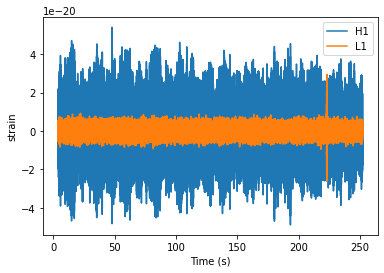

In [ ]:
# print (strain.delta_t)
pylab.plot(strain['H1'].sample_times, strain['H1'], label= 'H1')
pylab.plot(strain['L1'].sample_times, strain['L1'], label= 'L1')
pylab.legend()
pylab.xlabel('Time (s)')
pylab.ylabel('strain')
pylab.show()


b)

Write down the code to calculate the matched filter between the given data and a
template waveform. After that, find out the template waveform for which the signal
to noise ratio is maximum. For simplicity, you can assume the template waveform is
produced from an equal mass binary system. Produce a plot which shows the SNR
versus total mass of the system, where masses of the systems are uniformly distributed
in a range 1M ≤ m1,2 ≤ 3M (use m1 = m2). Represent the result by fitting the
best match template waveform against the data. Also, show the chirp structure of the
signal over the time-frequency domain using Q-transformation().

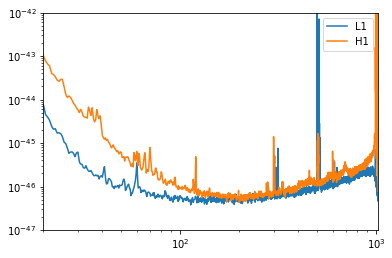

In [ ]:
#Power spectral density plot of the data
import pycbc.psd
from pycbc.psd import interpolate

psds = {}
for ifo in ['L1', 'H1']:
    delta_t = strain[ifo].delta_t
    seg_len = int(2 / delta_t)
    seg_stride = int(seg_len / 2)
    psds[ifo]  = pycbc.psd.welch(strain[ifo],
                      seg_len=seg_len,
                      seg_stride=seg_stride)
    
    psds[ifo] = interpolate(psds[ifo], stilde[ifo].delta_f)

    pylab.loglog(psds[ifo].sample_frequencies, psds[ifo], label=ifo)
    pylab.xlim(20, 1024)
    pylab.ylim(1e-47, 1e-42)
pylab.legend()

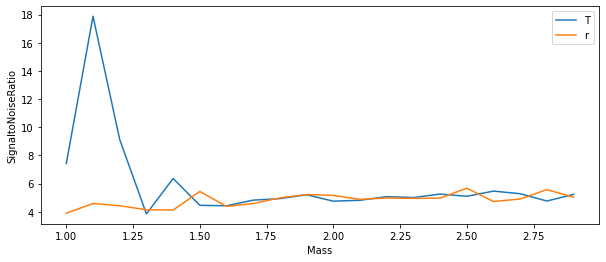

In [ ]:
from pycbc.filter import matched_filter
from pycbc.conversions import mass1_from_mchirp_q
import numpy
from pycbc.waveform import td_approximants, fd_approximants

#Solar masses from 1 to 3
mass1 = numpy.arange(1, 3, 0.1) #mass range between 1 and 3 Solar mass
mass2 = mass1

hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
snrs = {}
ifo = 'H1'
Snr_list = []
    #Generating the waveform for the given masses and nonspinning
for i in range(len(mass1)):
 
    mass = mass1[i] # Solar masses
    hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=mass,
                     mass2=mass,
                     delta_t=strain[ifo].delta_t,
                     f_lower=15.0)

    # We will resize the vector to match our data
    hp.resize(len(strain[ifo]))
    template = hp.cyclic_time_shift(hp.start_time)
    
    SignaltoNoise = matched_filter(template, strain[ifo],
                     psd=psds[ifo], low_frequency_cutoff=15.0)
    snr_H1 = SignaltoNoise.crop(8, 4) # 4 + 4


    Snr_list.append(max(abs(snr_H1)))
snrs[ifo] = Snr_list



ifo = 'L1'
Snr_list = []
for i in range(len(mass1)):
    #Generate a waveform with a given component mass; assumed equal mass, nonspinning
 
    mass = mass1[i] # Solar masses
    hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=mass,
                     mass2=mass,
                     delta_t=strain[ifo].delta_t,
                     f_lower=15.0)

    # We will resize the vector to match our data
    hp.resize(len(strain[ifo]))
    template = hp.cyclic_time_shift(hp.start_time)
    
    SignaltoNoise = matched_filter(template, strain[ifo],
                     psd=psds[ifo], low_frequency_cutoff=15.0)
    snr_H1 = SignaltoNoise.crop(8, 4)


    Snr_list.append(max(abs(snr_H1)))
snrs[ifo] = Snr_list

pylab.figure(figsize=[10, 4])
pylab.plot(mass1, snrs['H1'], label= 'H1')
pylab.plot(mass1, snrs['L1'], label= 'L1')
pylab.legend('True')
pylab.ylabel('SignaltoNoiseRatio')
pylab.xlabel('Mass')
pylab.show()

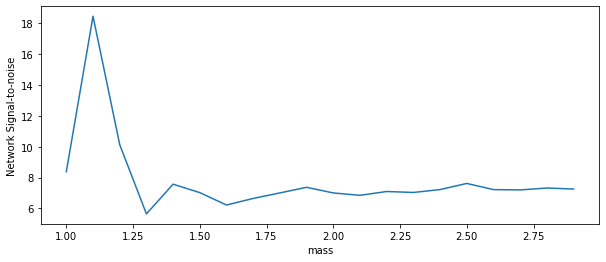

We found the best Mass1=Mass2 was 1.10 solar masses (detector frame)


In [ ]:
nsnr = (numpy.array(snrs['H1'])**2 + numpy.array(snrs['L1'])**2)**0.5
ii = numpy.where(nsnr == max(nsnr))
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, nsnr)

#Only plotting the signal to noise ratio network
pylab.ylabel('Network Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

SM = "We found the best Mass1=Mass2 was %2.2f solar masses (detector frame)" % mass1[ii]
print(SM)

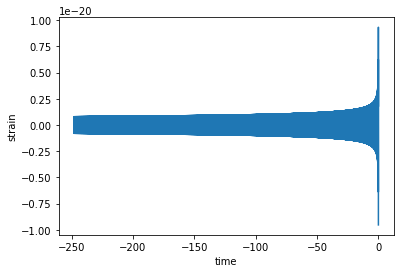

In [ ]:
m = 1.10 # In solar masses
conditioned = strain['H1']
hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=19.75)
hp.resize(len(conditioned))
template = hp .cyclic_time_shift(hp.start_time)
pylab.plot(hp.sample_times, template)
pylab.xlabel('time')
pylab.ylabel('strain')
pylab.show()

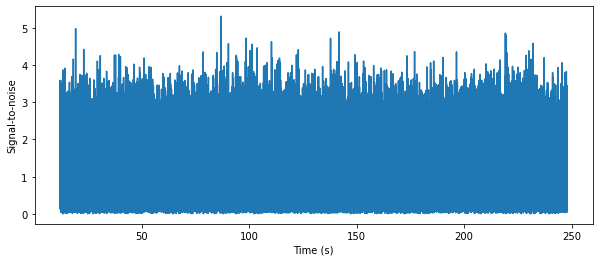

We found a signal at 87.046875s with SNR 5.308304601491556


In [ ]:
from pycbc.filter import matched_filter
import numpy

ifo = 'L1'                            
conditioned = strain[ifo]
snr = matched_filter(template, conditioned,
                     psd=psds[ifo] , low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4)
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

In [ ]:
# Can't verify this because the merger doesn't load... 
#But this should plot the original data and the data without the signal
from pycbc.filter import sigma

dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psds[ifo], low_frequency_cutoff=20.0)
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time
white_data = (conditioned.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()
tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()
white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
white_data = white_data.time_slice(merger.time-.2, merger.time+.1)
white_template = white_template.time_slice(merger.time-.2, merger.time+.1)
pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()

NameError: ignored

c)

Here, we would like to investigate the correlation in the parameter space of gravita-
tional waves from compact binary coalescences. Let us consider a gravitational wave
h∗(t; m1,m2) generated from a binary with masses m1 = m2 = 10M . Now, we want
to understand how the nearby templates are correlated with that waveform. Calculate
the match between h∗(t; m1,m2) and the nearby templates that are generated assum-
ing 5M ≤ m1,m2 ≤ 15M . Of course, one should have the maximum match (= 1)
when hi = h∗. You will see that the match between two nearby waveforms is not zero.
So, one can realize the gravitational waveforms are correlated for two nearby points
in the parameter space. This fact is used to produce a template bank for detecting
gravitational waves.

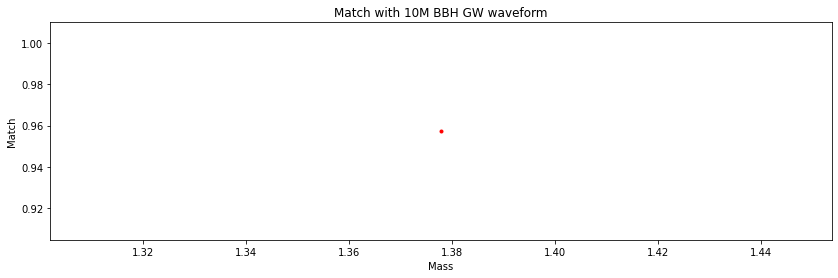

In [ ]:
from pycbc.waveform import get_td_waveform
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.conversions import mass1_from_mchirp_q

chirp_mass = numpy.arange(1.1966, 1.1996, .0001)
masses = mass1_from_mchirp_q(chirp_mass, 1)

sample_rate = 2048
matches = {}
mass_range = np.arange(5, 15, 0.1)
f_lower = 17.896

for mass in masses:
  hp, hc = get_td_waveform(approximant="EOBNRv2", mass1=10, mass2=10, f_lower=f_lower, delta_t=1.0/sample_rate) #create two waveforms to compare
  sp, sc = get_td_waveform(approximant="TaylorT4", mass1=10, mass2=10, f_lower=f_lower, delta_t=1.0/sample_rate)

# Resize the waveforms to the same length
tlen = max(len(sp), len(hp))
sp.resize(tlen)
hp.resize(tlen)
 
# Generate the aLIGO ZDHP PSD 
delta_f = 1.0 / sp.duration
flen = tlen//2 + 1
f_low=19.75
psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

# Note: This takes a while the first time as an FFT plan is generated 
# subsequent calls are much faster. 
m, i = match(hp, sp, psd=psd, low_frequency_cutoff=f_low)
matches[mass]=m

pylab.figure(figsize=[14, 4])
pylab.title("Match with 10M BBH GW waveform")
pylab.ylabel('Match')
pylab.xlabel('Mass')
pylab.plot(*zip(*matches.items()),'r.')
pylab.show()

PROBLEM 2

Load the data of the LIGO Hanford detector from [2]. Plot the noise power spectral
density (PSD) of that data. Test whether there is any gravitational wave signal present
in the data or not? For this test, you can assume the GW signals can produce only
from equal mass binary systems with a range between 5 to 10. We assume a threshold
on matched filter SNR of 8 to claim detection of GW.

In [ ]:
d = np.load('/content/drive/MyDrive/noise_ts_4096Hz.npy') #name of the data file noise_ts_4096Hz.npy
import pycbc.types
dt = d[:,0]  
data = pycbc.types.TimeSeries(d[:, 1], delta_t = dt) 

#merger = Merger("GW170817")
strain, stilde = {}, {}

strain[] = resample_to_delta_t(highpass(data, 15.0), 1.0/2048)
strain[] = strain[].crop(4, 4)
stilde[] = strain[].to_frequencyseries()


SyntaxError: ignored

In [ ]:
d = numpy.load('/content/drive/MyDrive/noise_ts_4096Hz.npy') 
time = d[:, 0] 
strain = d[:, 1] 
dt = d[:,0]  

data = pycbc.types.TimeSeries(d[:, 1], delta_t = dt) 

import pycbc.psd
white_data = (data.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

ValueError: ignored